# <center>  Principal Component Analysis and Boosting - 04/11/2020 </center>#

* <span style="color:red">Cours</span>            : MICAS911-Introduction-To-Statistical-Learning
* <span style="color:red">Auteur</span>           : Bounhar Abdelaziz
* <span style="color:red">Auteur</span>           : Yu Yeh
* <span style="color:red">Auteur</span>           : Panongbene Jean Mohamed Sawadogo

# <center> <span style="color:red"><font size="+3"> Assignment Principal Component Analysis and Boosting  </font></span> </center> #

# Exercice 2

AdaBoost algorithm for a two-class classification problem. The algorithm sequentially applies a weak classification to modified versions of the data. By increasing the weights of the missclassified observations, each weak learner focuses on the error of the previous one. The predictions are aggregated through a weighted majority vote.

In [3]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_hastie_10_2
import matplotlib.pyplot as plt
from tqdm import tqdm

In [16]:
# Useful starting lines
%matplotlib inline

%load_ext autoreload
%autoreload 2

from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Helpers Functions

In [5]:
def plot_error_rate(er_train, er_test):
    df_error = pd.DataFrame([er_train, er_test]).T
    df_error.columns = ['Training', 'Test']
    plot1 = df_error.plot(linewidth = 3, figsize = (8,6),
            color = ['lightblue', 'darkblue'], grid = True)
    plot1.set_xlabel('Number of iterations', fontsize = 12)
    plot1.set_xticklabels(range(0,450,50))
    plot1.set_ylabel('Error rate', fontsize = 12)
    plot1.set_title('Error rate vs number of iterations', fontsize = 16)
    plt.axhline(y=er_test[0], linewidth=1, color = 'red', ls = 'dashed')
    plt.savefig('adaboost.pdf',format='pdf')

In [6]:
def get_error_rate(pred, Y):
    return sum(pred != Y) / float(len(Y))

In [7]:
def print_error_rate(err):
    print('Error rate: Training: %.4f - Test: %.4f'.format(err))

## Weak Learners

In [8]:
def generic_clf(Y_train, X_train, Y_test, X_test, clf):
    clf.fit(X_train,Y_train)
    pred_train = clf.predict(X_train)
    pred_test = clf.predict(X_test)
    return get_error_rate(pred_train, Y_train),get_error_rate(pred_test, Y_test)

# Datasets :
##### Generates data for binary classification used in Hastie et al. 2009, Example 10.2.

In [9]:
# Read data
x, y = make_hastie_10_2()
df = pd.DataFrame(x)
df['Y'] = y

# Split into training and test set
train, test = train_test_split(df, test_size = 0.2)
X_train, Y_train = train.iloc[:,:-1], train.iloc[:,-1]
X_test, Y_test = test.iloc[:,:-1], test.iloc[:,-1]

In [10]:
# Fit a simple decision tree first
clf_tree = DecisionTreeClassifier(max_depth = 1, random_state = 1)
er_tree = generic_clf(Y_train, X_train, Y_test, X_test, clf_tree)
print('Single Weak Learner Achieves \n Train Error of {} \n Test Error of {}'.format(er_tree[0],er_tree[1]))

Single Weak Learner Achieves 
 Train Error of 0.4621875 
 Test Error of 0.485


# Implement an adaboost classifier

In [11]:
def adaboost_clf(Y_train, X_train, Y_test, X_test, M, clf):
    n_train, n_test = len(X_train), len(X_test)
    # Initialize weights
    w = np.ones(n_train) / n_train
    pred_train, pred_test = [np.zeros(n_train), np.zeros(n_test)]
    
    for i in range(M):
        # Fit a classifier with the specific weights
        clf.fit(X_train, Y_train, sample_weight = w)
        pred_train_i = clf.predict(X_train)
        pred_test_i = clf.predict(X_test)
        # Indicator function
        miss = 0
        # Equivalent with 1/-1 to update weights
        miss2 = 0
        # Error
        err_m = 0
        # Alpha
        alpha_m =0 
        # New weights
        w = 0
        # Add to prediction
        pred_train = [sum(x) for x in zip(pred_train, 
                                          [x * alpha_m for x in pred_train_i])]
        pred_test = [sum(x) for x in zip(pred_test, 
                                         [x * alpha_m for x in pred_test_i])]
    
    pred_train, pred_test = np.sign(pred_train), np.sign(pred_test)
    # Return error rate in train and test set
    return get_error_rate(pred_train, Y_train), get_error_rate(pred_test, Y_test)

# Fit Adaboost classifier using a decision tree as base estimator

In [ ]:
# Test with different number of iterations
er_train, er_test = [er_tree[0]], [er_tree[1]]
x_range = range(10, 400, 10)
for i in tqdm(x_range):
    er_i = adaboost_clf(Y_train, X_train, Y_test, X_test, i, clf_tree)
    er_train.append(er_i[0])
    er_test.append(er_i[1])
    
# Compare error rate vs number of iterations
plot_error_rate(er_train, er_test)

# PCA for dimensionality reduction and image denoising

In [17]:
from keras.datasets import mnist

Using TensorFlow backend.


In [18]:
import numpy as np
import matplotlib.pyplot as plt

In [270]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [271]:
x_train.shape

(60000, 28, 28)

In [272]:
len(x_train)

60000

In [273]:
x_train = x_train.reshape(len(x_train), -1)/255
x_test = x_test.reshape(len(x_test), -1)/255

In [274]:
x_train.shape

(60000, 784)

## Question 1. 

Compute the eigendecomposition of the sample covariance matrix and use the eigenvalues to calculate the percentage of variance explained (given by the eigenvalues).
Plot the cumulative sum of these percentages versus the number of components.

In [275]:
all_col_mean = np.mean(x_train,0) # np.mean(x,i) -> i : 0 for columns -- 1 for for rows
x_bar = x_train - all_col_mean

In [276]:
np.mean(x_bar,0) #The mean of each feature becomes close to zero.

array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        3.40529646e-18,  1.39278380e-17, -4.50261578e-18,  4.70037782e-19,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
       -4.23347660e-19, -1.01880601e-19, -2.22856952e-17, -6.53094671e-17,
       -2.24041416e-17, -2.08656081e-17, -1.87326005e-16, -9.07893733e-17,
        2.40054107e-17,  3.61286811e-17,  6.34269474e-18,  6.59362972e-18,
       -1.03516201e-16, -1.09649601e-16, -3.62047631e-17, -3.82090121e-17,
        3.95102607e-18, -6.34461423e-18,  6.08389456e-18,  3.87223004e-18,
        0.00000000e+00,  

In [277]:
cov_x = np.cov(x_bar.T) # check what would happen if we do the eigendecomp using X.t*X rather than using cov matrix (there should be a scalar diff)

# the scalar is (1/N-1) https://en.wikipedia.org/wiki/Sample_mean_and_covariance

In [278]:
cov_x.shape

(784, 784)

In [279]:
w, P = np.linalg.eig(cov_x)

In [284]:
d= 169
print(np.sum(w[:d]))
w = -np.sort(-w)
print(np.sum(w[:d]))

(50.42451300747386+0j)
(50.42451300747386+0j)


In [302]:
P[:1 , :169].real

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [154]:
print(w.shape)

(784,)


In [132]:
print(P.shape)

(784, 784)


In [164]:
w_kept = w[:d]
P_kept = np.diag(w_kept)

In [196]:
w_kept.real

array([ 5.11687301e+00,  3.74139084e+00,  3.25270845e+00,  2.84162070e+00,
        2.56711774e+00,  2.27366339e+00,  1.72515498e+00,  1.52056024e+00,
        1.45630525e+00,  1.24275009e+00,  1.11208951e+00,  1.06664054e+00,
        9.04680833e-01,  8.92181223e-01,  8.32353048e-01,  7.81900323e-01,
        6.98386871e-01,  6.73255811e-01,  6.25995240e-01,  6.07763020e-01,
        5.62145880e-01,  5.30798829e-01,  5.02780255e-01,  4.81147033e-01,
        4.65783200e-01,  4.42538691e-01,  4.28439606e-01,  4.14618707e-01,
        3.92667337e-01,  3.64261791e-01,  3.46985958e-01,  3.41741890e-01,
        3.17734284e-01,  3.09280821e-01,  3.00549034e-01,  2.86632712e-01,
        2.66680512e-01,  2.57227909e-01,  2.53838022e-01,  2.49006738e-01,
        2.40823990e-01,  2.34543854e-01,  2.20658652e-01,  2.09962678e-01,
        2.02981381e-01,  1.97776690e-01,  1.90872477e-01,  1.85379715e-01,
        1.79298798e-01,  1.69711256e-01,  1.68204657e-01,  1.64929264e-01,
        1.56059568e-01,  

In [163]:
P_kept = P[:500 , :500]

In [165]:
print(P_kept.shape)

(784, 784)


In [166]:
np.sum(P) - np.sum(P_kept)

(-16.74945215106718+0j)

In [138]:
percentage_eigen_value = [w[i]/np.sum(w) for i in range(len(w)) ]
sum(percentage_eigen_value)

(0.9999999999999998+0j)

c:\python36\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


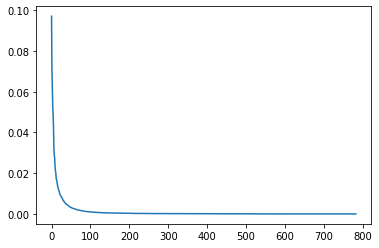

In [41]:
plt.plot(percentage_eigen_value)

In [43]:
my_cumulative_percentage_eigen_value = [np.sum(percentage_eigen_value[:i]) for i in range(len(w))]

In [44]:
cumulative_percentage_eigen_value = np.cumsum(percentage_eigen_value)

In [45]:
cumulative_percentage_eigen_value

array([0.09704664+0.00000000e+00j, 0.16800588+0.00000000e+00j,
       0.22969677+0.00000000e+00j, 0.28359097+0.00000000e+00j,
       0.33227894+0.00000000e+00j, 0.37540125+0.00000000e+00j,
       0.40812055+0.00000000e+00j, 0.4369595 +0.00000000e+00j,
       0.4645798 +0.00000000e+00j, 0.4881498 +0.00000000e+00j,
       0.5092417 +0.00000000e+00j, 0.52947161+0.00000000e+00j,
       0.54662979+0.00000000e+00j, 0.56355091+0.00000000e+00j,
       0.57933732+0.00000000e+00j, 0.59416685+0.00000000e+00j,
       0.60741246+0.00000000e+00j, 0.62018143+0.00000000e+00j,
       0.63205406+0.00000000e+00j, 0.6435809 +0.00000000e+00j,
       0.65424256+0.00000000e+00j, 0.66430969+0.00000000e+00j,
       0.67384542+0.00000000e+00j, 0.68297086+0.00000000e+00j,
       0.69180491+0.00000000e+00j, 0.7001981 +0.00000000e+00j,
       0.70832389+0.00000000e+00j, 0.71618755+0.00000000e+00j,
       0.72363488+0.00000000e+00j, 0.73054347+0.00000000e+00j,
       0.73712441+0.00000000e+00j, 0.74360589+0.0000000

In [46]:
np.allclose(cumulative_percentage_eigen_value, my_cumulative_percentage_eigen_value,  rtol=1e-05)

False

In [47]:
err_precision = 0
for i in range(len(cumulative_percentage_eigen_value)):
    err_i = cumulative_percentage_eigen_value[i] - my_cumulative_percentage_eigen_value[i]
    err_precision = err_precision + err_i
print("err_precision = ",err_precision)

err_precision =  (1.000000000000068+0j)


c:\python36\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


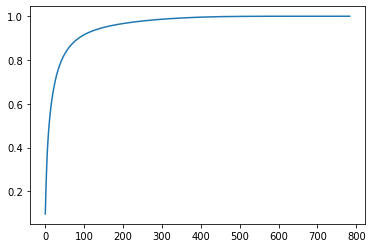

In [48]:
plt.plot(cumulative_percentage_eigen_value)

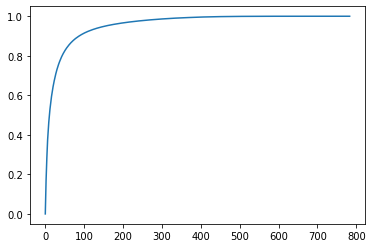

In [49]:
plt.plot(my_cumulative_percentage_eigen_value)

### Comments :

We can clearly see that more than 90% of the data is contained in the first 100 components. Which means that 100 components are sufficient to describe 90% of the data. We also observe that after, there's a certain monotonity, that is the other components doesn't add much informations.
This actually was predictible since in our images the real information (the number) is concentrated in few pixels.

We will build a function down bellow that will give us the exact number of dimensions to keep in order to keep a percentage of the original data.

In [56]:
def findNumberOfDimensionByDesiredCumulativePercentage(cumulative_percentage_eigen_value, desiredCumulativePercentage):
    """ 
    This function helps us find the number of principale components (dimensions) by keeping only the desired percentage
    of informations from the original data.
    """
    
    for i in range(len(cumulative_percentage_eigen_value)):
        if cumulative_percentage_eigen_value[i] >= desiredCumulativePercentage :
            return i

In [57]:
desiredCumulativePercentage = 0.90
findNumberOfDimensionByDesiredCumulativePercentage(cumulative_percentage_eigen_value, desiredCumulativePercentage)

86

* For example to keep 90% of informations of the data we can keep only 86 dimensions, which can be confirmerd from the figure above.

## Question 2
## PCA Algorithm

In [413]:
def PCA(X, forcedNbrDim, desiredCumulativePercentage=0.85, plot=False):
    
    all_col_mean = np.mean(X,0) # np.mean(x,i) -> i : 0 for columns -- 1 for for rows
    # we construct the X bar
    x_bar = X - all_col_mean 
    # covariance matrix
    cov_x = np.cov(x_bar.T)     
    # SVD
    w, P = np.linalg.eig(cov_x)
    
    percentage_eigen_value = [w[i]/np.sum(w) for i in range(len(w)) ]
    print("Sum of percentage_eigen_value : ", sum(percentage_eigen_value))
    cumulative_percentage_eigen_value = np.cumsum(percentage_eigen_value)
    
    if plot :
        plt.plot(cumulative_percentage_eigen_value)
    
    # number of dimensions to keep 
    if forcedNbrDim < 0: # we set a negative forcedDim if we want to use the computation from the cumulative percentage
        d = findNumberOfDimensionByDesiredCumulativePercentage(cumulative_percentage_eigen_value, desiredCumulativePercentage)
    else :
        d = forcedNbrDim
    
    # we keep only the d first eigein values of P
    
    P_kept = P[: , :d]
    print("P_kept : ",P_kept.shape)
    print("Dimensions to keep : ",d)
    #w_kept = w[:d] 
    #P_kept = np.diag(w_kept)
    #Y = np.dot(x_bar, P_kept.real)
    
    Y = np.dot(x_bar, P_kept)
    Xhat = np.dot(Y, P_kept.T) + all_col_mean
    
    # Errors computations
    X_fnom = np.linalg.norm(X, 'fro')
    M = X - Xhat
    M_fnorm = np.linalg.norm(M, 'fro')
    reconstructionError = M_fnorm/X_fnom
    print("Normalized reconstruction error : ",reconstructionError)
    return Xhat, Y, d, reconstructionError

In [414]:
desiredCumulativePercentage=0.85
forcedNbrDim = -1
Xhat, Y, d, reconstructionError = PCA(x_train, forcedNbrDim, desiredCumulativePercentage)

Sum of percentage_eigen_value :  (0.9999999999999998+0j)
P_kept :  (784, 58)
Dimensions to keep :  58
Normalized reconstruction error :  0.3024527547774581


In [415]:
print(x_train.shape)
print(Xhat.shape)
print(Y.shape)

(60000, 784)
(60000, 784)
(60000, 58)


In [416]:
Xhat[0].reshape(28,-1).shape

(28, 28)

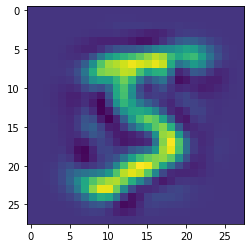

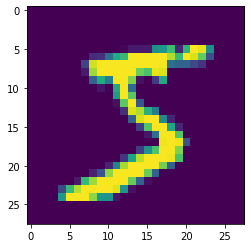

In [417]:
i = 0
y = Xhat[i].real.reshape(28,28)
plt.imshow(y)
plt.show()
y = x_train[i].real.reshape(28,28)
plt.imshow(y)

----------- p =  50 -------------
Sum of percentage_eigen_value :  (0.9999999999999998+0j)
P_kept :  (784, 50)
Dimensions to keep :  50
Normalized reconstruction error :  0.3244839105237107


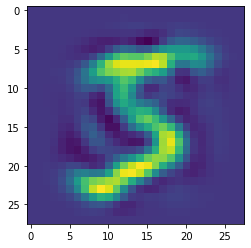

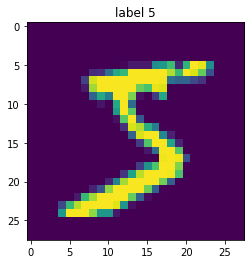



----------- p =  250 -------------
Sum of percentage_eigen_value :  (0.9999999999999998+0j)
P_kept :  (784, 250)
Dimensions to keep :  250
Normalized reconstruction error :  0.11476437541142882


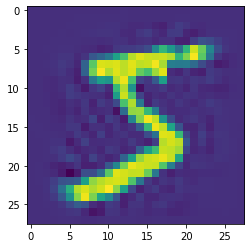

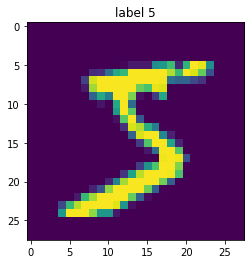



----------- p =  500 -------------
Sum of percentage_eigen_value :  (0.9999999999999998+0j)
P_kept :  (784, 500)
Dimensions to keep :  500
Normalized reconstruction error :  0.02121724407664908


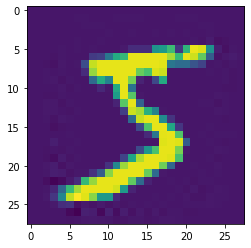

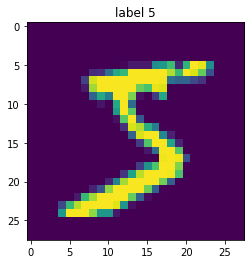



[0.3244839105237107, 0.11476437541142882, 0.02121724407664908]


In [420]:
dimensions = [50, 250, 500]
reconstructionErrors = []
for p in dimensions :
    print("----------- p = ",p,"-------------")
    Xhat, Y, d, reconstructionError = PCA(x_train, p, desiredCumulativePercentage)
    reconstructionErrors.append(reconstructionError)
    
    i = 0
    xhat_im = Xhat[i].real.reshape(28,28)
    plt.imshow(xhat_im)
    plt.show()
    x_im = x_train[i].real.reshape(28,28)
    plt.imshow(x_im)
    plt.title('label %d'%(y_train[i]))
    plt.show()
    print("\n")
    
print(reconstructionErrors)

## Playing with the images


## Question 3
### Adding Noise to image data

In [358]:
def generateNoise(data, sigma):
    
    bruit = sigma*np.random.rand(data.shape[0], data.shape[1])
    data_bruite = data + bruit
    data_bruite[0].reshape(28,28).shape
    
    return data_bruite
    
def plotImageData(nbrImageToPlot, data, label):
    
    for k in range(nbrImageToPlot):
        plt.imshow(data[k].reshape(28,28))
        plt.title('label %d'%(label[k]))
        plt.show()

def addNoiseToData(data, label, sigma, nbrImageToPlot) :
    
    data_bruite = generateNoise(data, sigma)
    plotImageData(nbrImageToPlot, data_bruite, label)
    
    return data_bruite

In [359]:
x_train[0].reshape(28,28).shape

(28, 28)

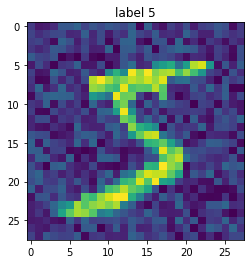

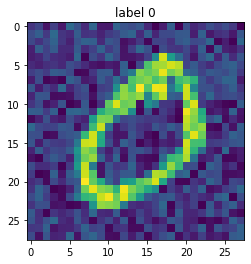

In [365]:
sigma2 = 0.25
nbrImageToPlot = 2
data_bruite = addNoiseToData(x_train, y_train, sigma, nbrImageToPlot)

Sum of percentage_eigen_value :  1.0000000000000002
P_kept :  (784, 76)
Dimensions to keep :  76
Normalized reconstruction error :  0.31913006790403686


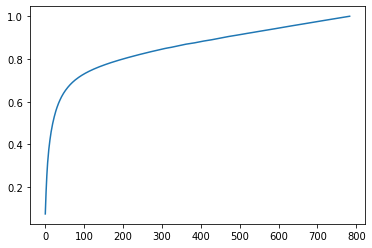

In [430]:
desiredCumulativePercentage=0.7
forcedNbrDim = -1
Xhat, Y, d, reconstructionError = PCA(data_bruite, forcedNbrDim, desiredCumulativePercentage, plot=True)

### Comments :

In the case where we added the noise, we don't have the same curve for the cumulative explained variance versus the number of components. In fact, this is due to the fact that when there's a noise in the data, each components adds informations and thus is no more useless.

We need 457 component to describe 90% of the data, which is almost 5 times higher than the first case without noise.

To put in contrast with we had seen in the first, here the real information is hidded by the noise rather then being clear and  concentrated in few pixels.

In [429]:
Xhat_test, Y, d, reconstructionError = PCA(data_bruite, forcedNbrDim, desiredCumulativePercentage=0.9)

Sum of percentage_eigen_value :  1.0000000000000002
P_kept :  (784, 457)
Dimensions to keep :  457
Normalized reconstruction error :  0.18409226885722665


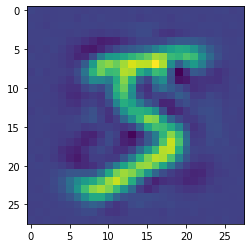

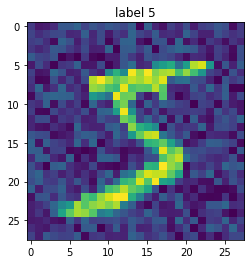

In [427]:
i = 0

xhat_im = Xhat[i].real.reshape(28,28)
plt.imshow(xhat_im)
plt.show()

x_im = data_bruite[i].real.reshape(28,28)
plt.imshow(x_im)
plt.title('label %d'%(y_train[i]))

plt.show()

## Question 4

----------- sigma2 =  0.15 -------------
Sum of percentage_eigen_value :  0.9999999999999994
P_kept :  (784, 48)
Dimensions to keep :  48
Normalized reconstruction error :  0.317197607479058


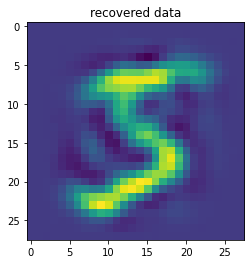

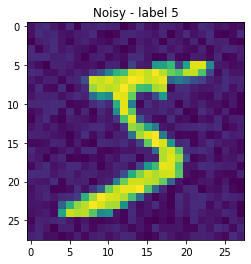



----------- sigma2 =  0.25 -------------
Sum of percentage_eigen_value :  1.0
P_kept :  (784, 61)
Dimensions to keep :  61
Normalized reconstruction error :  0.29643846958655573


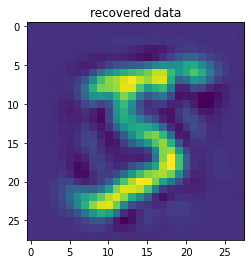

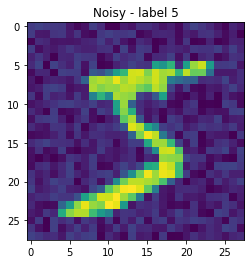



----------- sigma2 =  0.5 -------------
Sum of percentage_eigen_value :  0.9999999999999992
P_kept :  (784, 201)
Dimensions to keep :  201
Normalized reconstruction error :  0.26008258629277403


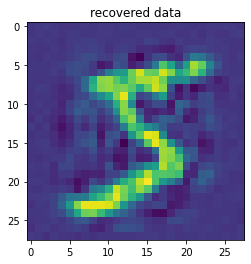

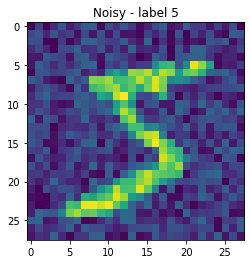



[0.317197607479058, 0.29643846958655573, 0.26008258629277403]


In [442]:
sigmas2 = [0.15, 0.25, 0.50]
reconstructionErrors = []
for sigma2 in sigmas2 :
    print("----------- sigma2 = ",sigma2,"-------------")
    data_bruite = addNoiseToData(x_train, y_train, sigma2, nbrImageToPlot=0)
    
    desiredCumulativePercentage= 0.8
    forcedNbrDim = -1
    Xhat, Y, d, reconstructionError = PCA(data_bruite, forcedNbrDim, desiredCumulativePercentage)
    reconstructionErrors.append(reconstructionError)
    
    i = 0
    xhat_im = Xhat[i].real.reshape(28,28)
    plt.imshow(xhat_im)
    plt.title("recovered data")
    plt.show()
    x_im = data_bruite[i].real.reshape(28,28)
    plt.imshow(x_im)
    plt.title('Noisy - label %d'%(y_train[i]))
    plt.show()
    print("\n")
    
print(reconstructionErrors)

### some trash

In [82]:
N = 2000 # number of samples

# Training samples
X_train = x_train[N:]/255
y_train = y_train[:N]

# Testing samples
X_test = x_train[N:]/255
y_test = y_test[:N]

In [79]:
print("Number of lines : ",len(X_test[0]))
print("Number of columns : ",len(X_test[0][0]))

Number of lines :  28
Number of columns :  28
